In [ ]:
from pathlib import Path
from pprint import pprint

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats.contingency import association

pd.set_option("display.max_rows", 20)
pd.set_option("display.max_columns", 10)
pd.set_option("display.max_colwidth", 50)
pd.set_option("display.width", 110)

In [39]:
# local paths
data_dir_src = Path('data/preprocess')
data_dir_dst = Path('data/eda')
data_dir_dst.mkdir(parents=True, exist_ok=True)

In [40]:
clinical = pd.read_parquet(data_dir_src / 'clinical.parquet')

# describe columns

In [41]:
# get categorical columns
clinical_cat = clinical.select_dtypes(include=['object', 'category', 'bool'])
print(clinical_cat.shape)

(506, 61)


In [42]:
_ = clinical_cat.describe().T
_ = _.rename(columns={'unique': 'n_unique', 'top': 'mode', 'freq': 'n_mode'})
_['n_na'] = clinical.shape[0] - _['count'] # number of missing values
_['p_na'] = _['n_na'] / clinical.shape[0] # proportion of missing values
_['p_mode'] = _['n_mode'] / clinical.shape[0] # proportion of mode values
_ = _.sort_values(['p_na', 'n_unique'])
with pd.option_context('display.max_rows', 100):
    print(_[['n_unique', 'p_na', 'p_mode']])

                                                   n_unique      p_na    p_mode
_cohort                                                   1       0.0       1.0
_primary_disease                                          1       0.0       1.0
_primary_site                                             1       0.0       1.0
tumor_tissue_site                                         1       0.0       1.0
gender                                                    2       0.0  0.535573
history_of_neoadjuvant_treatment                          2       0.0  0.994071
other_dx                                                  4       0.0  0.822134
icd_o_3_site                                              6       0.0   0.58498
icd_10                                                    7       0.0  0.598814
pathologic_T                                              9       0.0  0.320158
histological_type                                        12       0.0  0.616601
icd_o_3_histology                       

# drop columns

In [43]:
# drop clinical columns based on the above results
max_p_na = 0.2
max_p_mode = 0.95

mask = (_['p_na'] <= max_p_na) & (_['p_mode'] <= max_p_mode)
cols_to_keep = _.index[mask]
clinical_cat = clinical_cat.loc[:, clinical_cat.columns.isin(cols_to_keep)]
pprint(clinical_cat.columns.to_list())

['anatomic_neoplasm_subdivision',
 'gender',
 'histological_type',
 'icd_10',
 'icd_o_3_histology',
 'icd_o_3_site',
 'other_dx',
 'pathologic_M',
 'pathologic_N',
 'pathologic_T',
 'pathologic_stage',
 'person_neoplasm_cancer_status',
 'primary_therapy_outcome_success',
 'radiation_therapy',
 'targeted_molecular_therapy']


# inspect remaining columns

In [44]:
with pd.option_context('display.max_rows', 100):
    for col in clinical_cat:
        print()
        print(clinical_cat[col].value_counts(dropna=False))


anatomic_neoplasm_subdivision
R-Upper                   179
L-Upper                   119
R-Lower                    96
L-Lower                    77
R-Middle                   23
[Discrepancy]               5
Other (please specify)      4
None                        3
Name: count, dtype: int64

gender
FEMALE    271
MALE      235
Name: count, dtype: int64

histological_type
Lung Adenocarcinoma- Not Otherwise Specified (NOS)    312
Lung Adenocarcinoma Mixed Subtype                     107
Lung Papillary Adenocarcinoma                          22
Lung Bronchioloalveolar Carcinoma Nonmucinous          19
Lung Acinar Adenocarcinoma                             18
Mucinous (Colloid) Carcinoma                           10
Lung Bronchioloalveolar Carcinoma Mucinous              5
Lung Solid Pattern Predominant Adenocarcinoma           5
Lung Micropapillary Adenocarcinoma                      3
Lung Clear Cell Adenocarcinoma                          2
Lung Mucinous Adenocarcinoma              

# colinearity

In [45]:
cramersv = []
for col1 in clinical_cat:
    for col2 in clinical_cat:
        if col1 <= col2:
            continue
        ctab = pd.crosstab(clinical_cat[col1], clinical_cat[col2], dropna=False)
        cramersv.append({
            'col1': col1,
            'col2': col2,
            'df1': ctab.shape[0],
            'df2': ctab.shape[1],
            'size': ctab.shape[0] * ctab.shape[1],
            'cramersv': association(ctab, method='cramer') # bounded by (0, 1)
        })
cramersv = pd.DataFrame(cramersv)
cramersv = cramersv.sort_values('cramersv', ascending=False).reset_index(drop=True)
print(cramersv.head(20))


                               col1                             col2  df1  df2  size  cramersv
0                      icd_o_3_site                           icd_10    6    7    42  0.938833
1                 icd_o_3_histology                histological_type   12   12   144  0.894092
2                  pathologic_stage                     pathologic_N   11    6    66  0.706409
3        targeted_molecular_therapy                radiation_therapy    3    3     9  0.703124
4                      icd_o_3_site    anatomic_neoplasm_subdivision    6    8    48  0.649884
5                            icd_10    anatomic_neoplasm_subdivision    7    8    56  0.603911
6                  pathologic_stage                     pathologic_M   11    6    66  0.496063
7                  pathologic_stage                     pathologic_T   11    9    99  0.492383
8                 radiation_therapy  primary_therapy_outcome_success    3    6    18  0.487036
9        targeted_molecular_therapy  primary_thera

In [46]:
def side_by_side_plot(col1, col2, figsize=(10, 4)):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=figsize)
    clinical_cat[col1].value_counts(dropna=False).rename(col1).plot(kind='bar', ax=axes[0], subplots=True)
    clinical_cat[col2].value_counts(dropna=False).rename(col2).plot(kind='bar', ax=axes[1], subplots=True)
    axes[0].set_xlabel('')
    axes[1].set_xlabel('')

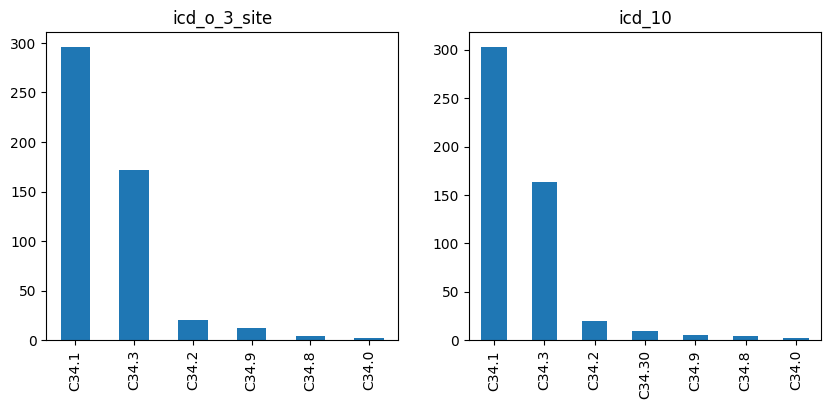

In [47]:
side_by_side_plot('icd_o_3_site', 'icd_10')
# drop icd_10 since it has a typo (C34.30 should be C34.3)
# merge rare classes for icd_o_3_site

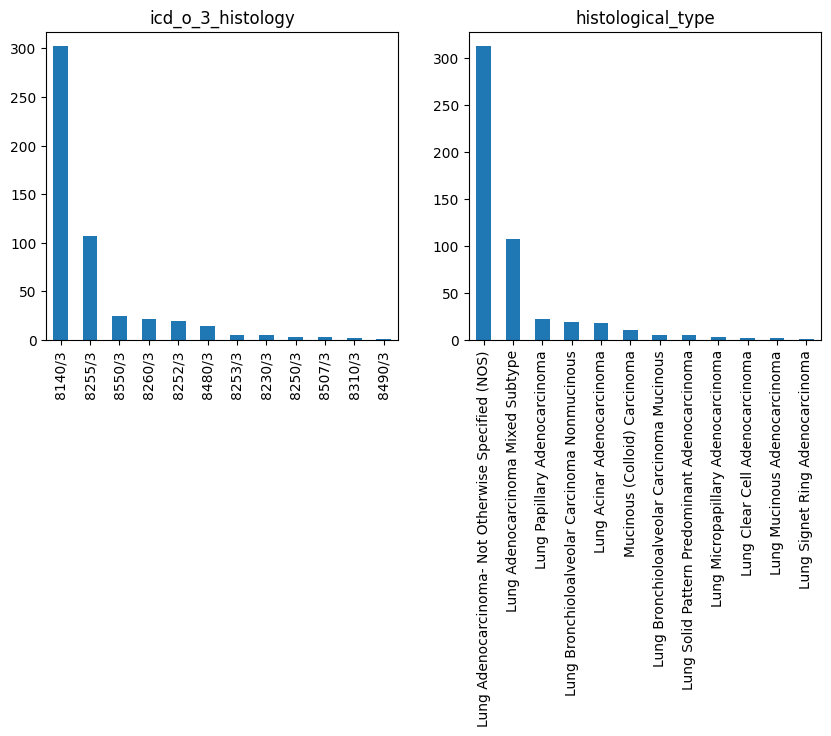

In [48]:
side_by_side_plot('icd_o_3_histology', 'histological_type')
# drop histological_type since icd_o_3_histology is more standardised re external datasets
# merge rare classes for icd_o_3_histology

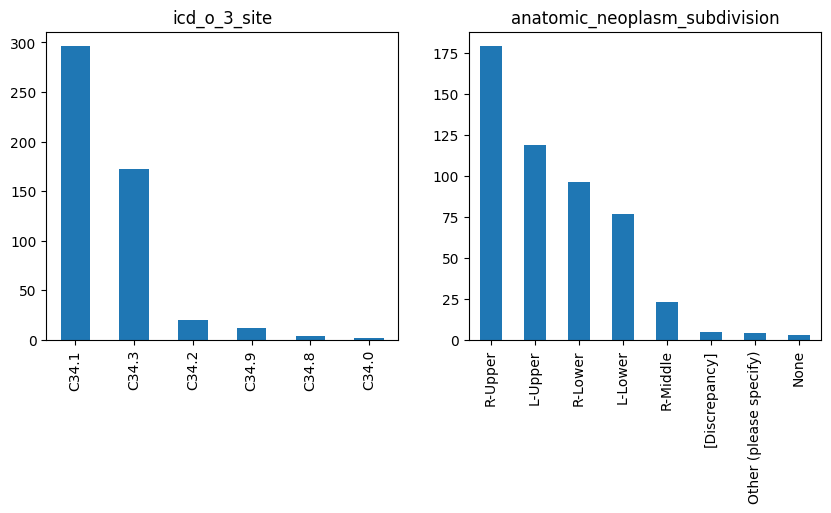

In [49]:
side_by_side_plot('icd_o_3_site', 'anatomic_neoplasm_subdivision')
# drop anatomic_neoplasm_subdivision since it has some missing values and has higher cardinality

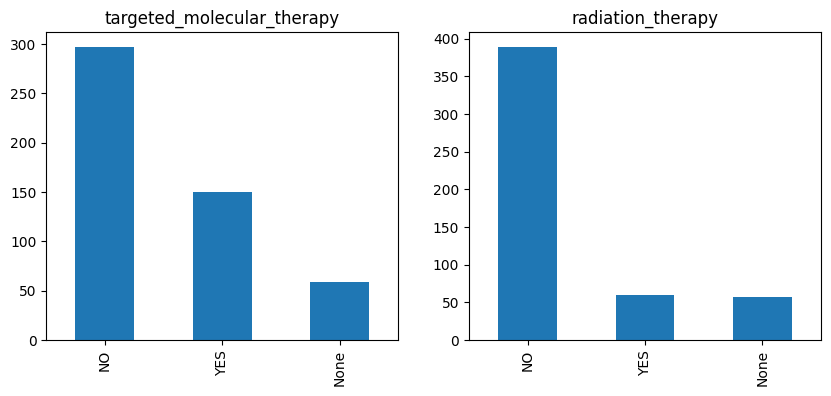

In [50]:
side_by_side_plot('targeted_molecular_therapy', 'radiation_therapy')
# keep both asis

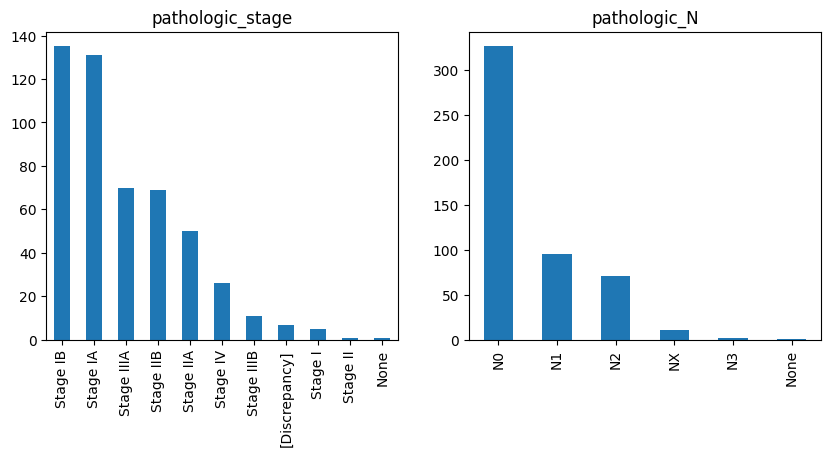

In [51]:
side_by_side_plot('pathologic_stage', 'pathologic_N')
# keep pathologic_stage but merge classes
# keep pathologic_N but merge non-NO classes (N0 = No lymph node involvement)

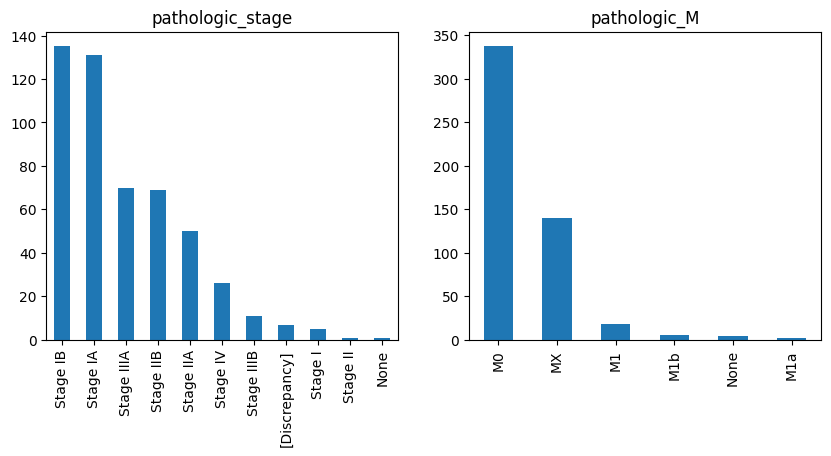

In [52]:
side_by_side_plot('pathologic_stage', 'pathologic_M')
# keep pathologic_stage but merge classes
# keep pathologic_M but merge non-MO classes (M0 = No distant metastasis)

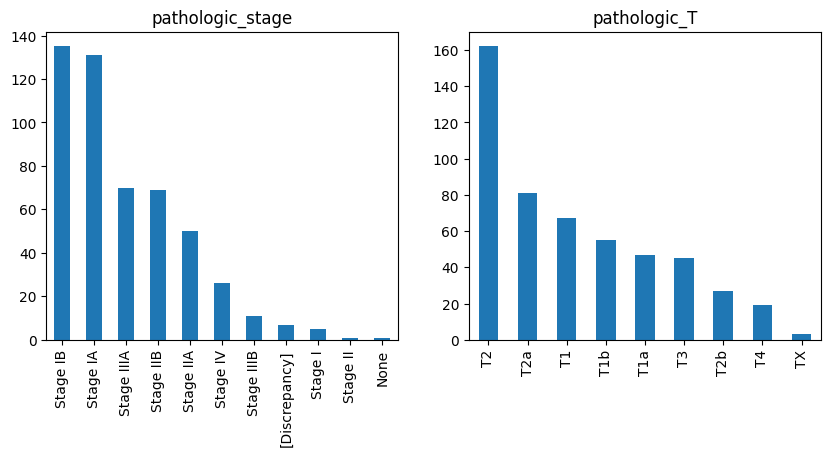

In [53]:
side_by_side_plot('pathologic_stage', 'pathologic_T')

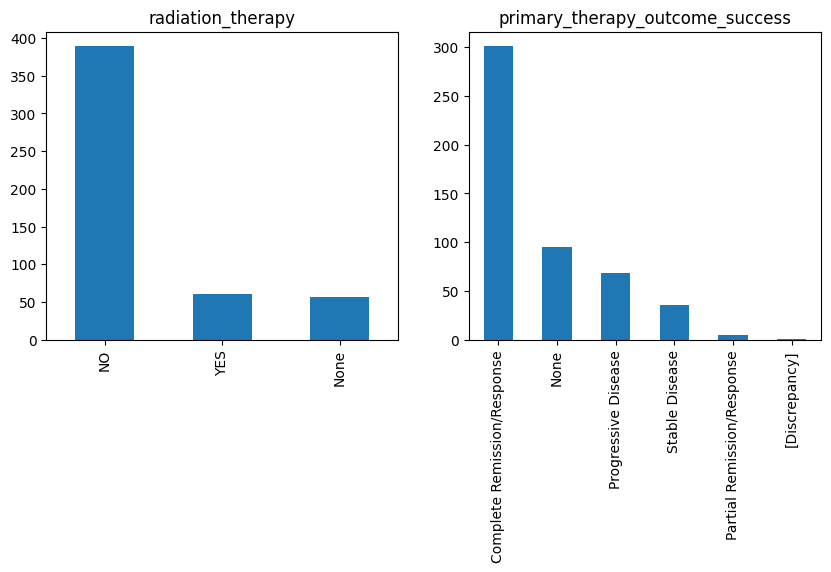

In [54]:
side_by_side_plot('radiation_therapy', 'primary_therapy_outcome_success')
# merge primary_therapy_outcome_success classes

In [55]:
clinical_cat['primary_therapy_outcome_success'].value_counts(dropna=False)

primary_therapy_outcome_success
Complete Remission/Response    301
None                            95
Progressive Disease             68
Stable Disease                  36
Partial Remission/Response       5
[Discrepancy]                    1
Name: count, dtype: int64

In [56]:
cols_to_drop = [
    'icd_10', 
    'histological_type', 
    'anatomic_neoplasm_subdivision',
]

clinical_cat = clinical_cat.loc[:, ~clinical_cat.columns.isin(cols_to_drop)]
print(clinical_cat.shape)

(506, 12)


# feature engineering

I.e. merge classes to reduce dimensionality and to combine rare classes.

In [57]:
col = 'other_dx'
clinical_cat[col] = clinical_cat[col]\
    .replace("Yes, History of Prior Malignancy", "Yes")\
    .replace("Yes, History of Synchronous/Bilateral Malignancy", "Yes")
clinical_cat[col].value_counts(dropna=False)    

other_dx
No     416
Yes     90
Name: count, dtype: int64

In [58]:
col = 'icd_o_3_site'
clinical_cat[col] = clinical_cat[col]\
    .replace("C34.2", "OTHER")\
    .replace("C34.9", "OTHER")\
    .replace("C34.8", "OTHER")\
    .replace("C34.0", "OTHER")
clinical_cat[col].value_counts(dropna=False)    

icd_o_3_site
C34.1    296
C34.3    172
OTHER     38
Name: count, dtype: int64

In [59]:
col = 'icd_o_3_histology'
clinical_cat[col] = clinical_cat[col]\
    .replace("8550/3", "OTHER")\
    .replace("8260/3", "OTHER")\
    .replace("8252/3", "OTHER")\
    .replace("8480/3", "OTHER")\
    .replace("8253/3", "OTHER")\
    .replace("8230/3", "OTHER")\
    .replace("8250/3", "OTHER")\
    .replace("8507/3", "OTHER")\
    .replace("8310/3", "OTHER")\
    .replace("8490/3", "OTHER")
clinical_cat[col].value_counts(dropna=False) 

icd_o_3_histology
8140/3    302
8255/3    107
OTHER      97
Name: count, dtype: int64

In [60]:
col = 'person_neoplasm_cancer_status'
clinical_cat[col] = clinical_cat[col]\
    .replace("[Discrepancy]", 'UNKNOWN')\
    .replace(np.nan, 'UNKNOWN')
clinical_cat[col].value_counts(dropna=False)    

person_neoplasm_cancer_status
TUMOR FREE    289
WITH TUMOR    164
UNKNOWN        53
Name: count, dtype: int64

In [61]:
# primary tumour
# T0: No tumor is present. There is no evidence of a primary tumor.
# T1: The tumor is small and has not spread significantly. For example, in some cancers, it may be confined to the inner lining of an organ.
# T2: The tumor has grown larger and may have invaded a deeper layer of tissue.
# T3: The tumor is larger and may have grown into nearby tissue or the outer lining of an organ.
# T4: The tumor is the largest and most advanced, having spread into nearby structures, such as muscle, bone, skin, or other organs. 
# TX: The tumor cannot be measured or evaluated.
col = 'pathologic_T'
clinical_cat[col] = clinical_cat[col]\
    .replace("T1a", "T1")\
    .replace("T1b", "T1")\
    .replace("T2a", "T2")\
    .replace("T2b", "T2")\
    .replace("T3", "T3/4")\
    .replace("T4", "T3/4")
clinical_cat[col].value_counts(dropna=False).sort_index()    

pathologic_T
T1      169
T2      270
T3/4     64
TX        3
Name: count, dtype: int64

In [62]:
# lymph nodes
# N0: No regional lymph nodes contain cancer cells.
# N1: Cancer has spread to lymph nodes within the lung or in the area where the main airway joins the lung (ipsilateral hilar and/or peribronchial lymph nodes). These nodes are on the same side as the primary tumor.
# N2: Cancer has spread to lymph nodes located in the space between the lungs (mediastinum) or just under the windpipe branches (subcarinal lymph nodes), but they are still on the same side (ipsilateral) as the main tumor.
# N3: Cancer has spread to lymph nodes that are further away, including those on the opposite side (contralateral) of the chest, near the collarbone (supraclavicular), or in the neck (scalene). 
# NX: can't be assessed
col = 'pathologic_N'
clinical_cat[col] = clinical_cat[col]\
    .replace("N1", "N1/N2/N3")\
    .replace("N2", "N1/N2/N3")\
    .replace("N3", "N1/N2/N3")\
    .replace("NX", 'UNKNOWN')\
    .replace(np.nan, 'UNKNOWN')
clinical_cat[col].value_counts(dropna=False)    

pathologic_N
N0          326
N1/N2/N3    168
UNKNOWN      12
Name: count, dtype: int64

In [63]:
# metastasis
col = 'pathologic_M'
clinical_cat[col] = clinical_cat[col]\
    .replace("M1a", "M1")\
    .replace("M1b", "M1")\
    .replace("MX", 'UNKNOWN')\
    .replace(np.nan, 'UNKNOWN')
clinical_cat[col].value_counts(dropna=False).sort_index()    

pathologic_M
M0         337
M1          25
UNKNOWN    144
Name: count, dtype: int64

In [64]:
col = 'pathologic_stage'
clinical_cat[col] = clinical_cat[col]\
    .replace("Stage IA", "Stage I")\
    .replace("Stage IB", "Stage I")\
    .replace("Stage IIA", "Stage II")\
    .replace("Stage IIB", "Stage II")\
    .replace("Stage III", "Stage III/IV")\
    .replace("Stage IIIA", "Stage III/IV")\
    .replace("Stage IIIB", "Stage III/IV")\
    .replace("Stage IV", "Stage III/IV")\
    .replace("[Discrepancy]", "UNKNOWN")\
    .replace(np.nan, 'UNKNOWN')
clinical_cat[col].value_counts(dropna=False)    

pathologic_stage
Stage I         271
Stage II        120
Stage III/IV    107
UNKNOWN           8
Name: count, dtype: int64

In [65]:
col = 'primary_therapy_outcome_success'
clinical_cat[col] = clinical_cat[col]\
    .replace("Complete Remission/Response", "Complete/Partial Remission/Response")\
    .replace("Partial Remission/Response", "Complete/Partial Remission/Response")\
    .replace("Progressive Disease", "Progressive/Stable Disease")\
    .replace("Stable Disease", "Progressive/Stable Disease")\
    .replace("[Discrepancy]", "UNKNOWN")\
    .replace(np.nan, 'UNKNOWN')
clinical_cat[col].value_counts(dropna=False)    

primary_therapy_outcome_success
Complete/Partial Remission/Response    306
Progressive/Stable Disease             104
UNKNOWN                                 96
Name: count, dtype: int64

# re-inspect columns

In [66]:
with pd.option_context('display.max_rows', 1000):
    for col in clinical_cat:
        print()
        print(clinical_cat[col].value_counts(dropna=False))


gender
FEMALE    271
MALE      235
Name: count, dtype: int64

icd_o_3_histology
8140/3    302
8255/3    107
OTHER      97
Name: count, dtype: int64

icd_o_3_site
C34.1    296
C34.3    172
OTHER     38
Name: count, dtype: int64

other_dx
No     416
Yes     90
Name: count, dtype: int64

pathologic_M
M0         337
UNKNOWN    144
M1          25
Name: count, dtype: int64

pathologic_N
N0          326
N1/N2/N3    168
UNKNOWN      12
Name: count, dtype: int64

pathologic_T
T2      270
T1      169
T3/4     64
TX        3
Name: count, dtype: int64

pathologic_stage
Stage I         271
Stage II        120
Stage III/IV    107
UNKNOWN           8
Name: count, dtype: int64

person_neoplasm_cancer_status
TUMOR FREE    289
WITH TUMOR    164
UNKNOWN        53
Name: count, dtype: int64

primary_therapy_outcome_success
Complete/Partial Remission/Response    306
Progressive/Stable Disease             104
UNKNOWN                                 96
Name: count, dtype: int64

radiation_therapy
NO      389

# re-check colinearity

In [67]:
cramersv = []
for col1 in clinical_cat:
    for col2 in clinical_cat:
        if col1 <= col2:
            continue
        ctab = pd.crosstab(clinical_cat[col1], clinical_cat[col2], dropna=False)
        cramersv.append({
            'col1': col1,
            'col2': col2,
            'df1': ctab.shape[0],
            'df2': ctab.shape[1],
            'size': ctab.shape[0] * ctab.shape[1],
            'cramersv': association(ctab, method='cramer') # bounded by (0, 1)
        })
cramersv = pd.DataFrame(cramersv)
cramersv = cramersv.sort_values('cramersv', ascending=False).reset_index(drop=True)
print(cramersv.head(20))

                               col1                             col2  df1  df2  size  cramersv
0        targeted_molecular_therapy                radiation_therapy    3    3     9  0.703124
1                  pathologic_stage                     pathologic_N    4    3    12  0.556934
2                 radiation_therapy  primary_therapy_outcome_success    3    3     9  0.475583
3        targeted_molecular_therapy  primary_therapy_outcome_success    3    3     9  0.461283
4   primary_therapy_outcome_success    person_neoplasm_cancer_status    3    3     9  0.456343
5                      pathologic_T                     pathologic_N    4    3    12  0.379893
6        targeted_molecular_therapy                 pathologic_stage    3    4    12  0.369755
7                  pathologic_stage                     pathologic_M    4    3    12  0.314049
8                  pathologic_stage                     pathologic_T    4    4    16  0.296512
9        targeted_molecular_therapy               

# write

In [68]:
clinical_cat.to_parquet(data_dir_dst / 'clinical_cat.parquet', compression='snappy')